In [61]:
#================================================================================
# 1) Colab 셀 1: 필수 라이브러리 설치 / 불러오기
#================================================================================
import os
import random
import math
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
#================================================================================
# 2) Colab 셀 2: 데이터셋 클래스 정의
#================================================================================
class MazeSeqDataset(Dataset):
    """
    training_data.txt 한 줄씩을 읽어서
    - 입력 (input): [ start_node_id, end_node_id ]  (토큰 인덱스 리스트)
    - 출력 (target): [ D=5, TYPE=Corridor, TURN_RIGHT, ..., END ]  (토큰 인덱스 리스트)
    """
    def __init__(self, data_path, token2idx=None, build_vocab=False):
        """
        data_path: 학습 데이터 파일 경로 (training_data.txt)
        token2idx: 이미 만들어진 토큰 사전 (input/output 공용)
        build_vocab: True이면 파일을 전체 스캔하여 토큰 사전 생성
        """
        self.pairs = []    # (input_tokens, output_tokens)
        self.token2idx = token2idx or {}
        self.build_vocab = build_vocab

        # 토큰을 모을 때 사용되는 임시 집합
        self._all_tokens = set()

        # 1) raw_data 읽기
        with open(data_path, 'r', encoding='utf-8') as f:
            lines = [ line.strip() for line in f if line.strip() ]

        # 2) 각 줄 파싱
        for line in tqdm(lines, desc="Parsing data"):
            # 예시: "1f_1 1f_2 | D=5 TYPE=Corridor TURN_RIGHT D=5 TYPE=Room END"
            sp = line.split('|')
            lhs = sp[0].strip()
            rhs = sp[1].strip()
            start_id, end_id = lhs.split()

            input_tokens = [start_id, end_id]
            output_tokens = rhs.split()

            # build_vocab=True 이면 토큰 집합에 추가
            if self.build_vocab:
                for tok in input_tokens:
                    self._all_tokens.add(tok)
                for tok in output_tokens:
                    self._all_tokens.add(tok)

            self.pairs.append((input_tokens, output_tokens))

        # 3) vocab 생성 (build_vocab=True 일 때만)
        if self.build_vocab:
            # special tokens
            specials = ['<PAD>', '<SOS>', '<EOS>']
            idx = 0
            for sp_tok in specials:
                self.token2idx[sp_tok] = idx
                idx += 1
            # 나머지 토큰
            for tok in sorted(self._all_tokens):
                if tok not in self.token2idx:
                    self.token2idx[tok] = idx
                    idx += 1
            print(f"Vocab size: {len(self.token2idx)}")

        # 4) token2idx이 없으면 에러
        if not self.token2idx:
            raise ValueError("token2idx is empty. Pass build_vocab=True at least once.")

        # 5) input/output 인덱스 변환 (idx2token 출력이 필요하면 추후 만들어도 됨)
        self.data = []
        for (ins, outs) in self.pairs:
            # 입력: <SOS> start end <EOS>
            in_idx = [ self.token2idx['<SOS>'] ]
            in_idx += [ self.token2idx[t] for t in ins ]
            in_idx += [ self.token2idx['<EOS>'] ]
            # 출력: <SOS> tok1 tok2 ... tokN <EOS>
            out_idx = [ self.token2idx['<SOS>'] ]
            out_idx += [ self.token2idx[t] for t in outs ]
            out_idx += [ self.token2idx['<EOS>'] ]
            self.data.append( (in_idx, out_idx) )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def collate_fn(batch):
        """
        batch: [(in_idx_list, out_idx_list), …]
        -> 입력, 출력 패딩 처리하여 Tensor(batch_size, max_len)로 반환
        """
        in_seqs, out_seqs = zip(*batch)
        in_lens = [len(s) for s in in_seqs]
        out_lens = [len(s) for s in out_seqs]

        max_in = max(in_lens)
        max_out = max(out_lens)

        PAD = 0  # '<PAD>' 토큰 인덱스가 0이라고 가정

        in_batch = []
        for s in in_seqs:
            padded = s + [PAD] * (max_in - len(s))
            in_batch.append(padded)
        out_batch = []
        for s in out_seqs:
            padded = s + [PAD] * (max_out - len(s))
            out_batch.append(padded)

        in_tensor = torch.tensor(in_batch, dtype=torch.long)
        out_tensor = torch.tensor(out_batch, dtype=torch.long)
        in_lens_t = torch.tensor(in_lens, dtype=torch.long)
        out_lens_t = torch.tensor(out_lens, dtype=torch.long)

        return in_tensor, in_lens_t, out_tensor, out_lens_t

In [64]:
#================================================================================
# 3) Colab 셀 3: 데이터 불러와서 vocab 만들기 & train/val 분리
#================================================================================
DATA_PATH = 'training_data.txt'

# 1) build_vocab=True 로 데이터셋 인스턴스 생성 → token2idx 얻기
full_ds_vocab = MazeSeqDataset(data_path=DATA_PATH, build_vocab=True)
token2idx = full_ds_vocab.token2idx
vocab_size = len(token2idx)
print("Final vocab size:", vocab_size)

# 2) 같은 데이터셋을 token2idx 고정하고 다시 생성
full_ds = MazeSeqDataset(data_path=DATA_PATH, token2idx=token2idx, build_vocab=False)

# 3) train/val 분리 (예: 90% train, 10% val)
total_len = len(full_ds)
train_len = int(total_len * 0.9)
val_len = total_len - train_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len])

print(f"Total samples: {total_len}, Train: {train_len}, Val: {val_len}")

# 4) DataLoader 구성
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=MazeSeqDataset.collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=MazeSeqDataset.collate_fn)


Parsing data: 100%|██████████| 68382/68382 [00:01<00:00, 68125.19it/s]


Vocab size: 288
Final vocab size: 288


Parsing data: 100%|██████████| 68382/68382 [00:00<00:00, 296841.92it/s]


Total samples: 68382, Train: 61543, Val: 6839


In [65]:
#================================================================================
# 4) Colab 셀 4: Seq2Seq 모델 (Encoder-Decoder) 정의
#================================================================================
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, rnn_type='LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'LSTM' or 'GRU'")
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, lengths):
        """
        x: (batch_size, seq_len) LongTensor
        lengths: (batch_size,) 실 입력 길이
        return:
          outputs: packed RNN outputs (ignored)
          hidden: 최종 hidden state (h_n, c_n) 또는 h_n
        """
        embedded = self.embedding(x)  # (B, T, E)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        return hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, rnn_type='LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, vocab_size)
        self.rnn_type = rnn_type

    def forward(self, tgt_seq, hidden, teacher_forcing_ratio=0.0):
        """
        tgt_seq: (batch_size, max_len) LongTensor, <SOS> ... <EOS> 포함
        hidden: encoder에서 넘어온 hidden state
        teacher_forcing_ratio: teacher forcing 확률 (0~1)
        """
        batch_size, max_len = tgt_seq.size()
        # 결과 logits: (batch_size, max_len, vocab_size)
        outputs = torch.zeros(batch_size, max_len, vocab_size, device=device)

        # 초기 입력 토큰은 모두 <SOS>
        input_tok = tgt_seq[:, 0].unsqueeze(1)  # (B, 1)  항상 <SOS> 토큰 인덱스

        # decoder hidden 초기화
        dec_hidden = hidden

        for t in range(1, max_len):
            emb = self.embedding(input_tok)  # (B, 1, E)
            if self.rnn_type == 'LSTM':
                out, dec_hidden = self.rnn(emb, dec_hidden)
            else:
                out, dec_hidden = self.rnn(emb, dec_hidden)
            # out: (B, 1, hidden_dim)
            logit = self.out(out.squeeze(1))  # (B, vocab_size)
            outputs[:, t, :] = logit

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = logit.argmax(dim=1).unsqueeze(1)  # (B,1)
            next_input = tgt_seq[:, t].unsqueeze(1) if teacher_force else top1
            input_tok = next_input

        return outputs

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, rnn_type='LSTM'):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, hidden_dim, num_layers, rnn_type)
        self.decoder = Decoder(vocab_size, embed_dim, hidden_dim, num_layers, rnn_type)

    def forward(self, src, src_lens, tgt, teacher_forcing_ratio=0.5):
        """
        src: (B, src_len)
        src_lens: (B,)
        tgt: (B, tgt_len)
        """
        enc_hidden = self.encoder(src, src_lens)
        dec_outs = self.decoder(tgt, enc_hidden, teacher_forcing_ratio)
        return dec_outs


In [66]:
#================================================================================
# 5) Colab 셀 5: 학습 및 평가 함수 정의
#================================================================================
def train_epoch(model, dataloader, optimizer, criterion, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0.0
    for src, src_lens, tgt, tgt_lens in tqdm(dataloader, desc="Train batches"):
        src = src.to(device)
        src_lens = src_lens.to(device)
        tgt = tgt.to(device)
        tgt_lens = tgt_lens.to(device)

        optimizer.zero_grad()
        # 모델 출력: (B, tgt_len, vocab_size)
        output_logits = model(src, src_lens, tgt, teacher_forcing_ratio)
        # loss 계산: CrossEntropyLoss (PAD 인덱스 무시)
        # output_logits[:, t, :] 은 t 시각 예측 logits
        # tgt[:, t] 는 정답 인덱스
        output_dim = output_logits.size(-1)
        B, T, V = output_logits.size()
        logits_flat = output_logits[:, 1:, :].reshape(-1, V)    # <SOS> 위치 제외
        target_flat = tgt[:, 1:].reshape(-1)                    # 동일하게 shift
        loss = criterion(logits_flat, target_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

@torch.no_grad()

def count_valid_tokens(tensor_row, pad_idx):
    return (tensor_row != pad_idx).sum().item()

def evaluate(model, dataloader, criterion, pad_idx):
    model.eval()
    total_sentences = 0
    exact_matches = 0
    total_loss = 0.0
    length_correct_total = {}

    with torch.no_grad():
        for src, src_lens, tgt, tgt_lens in tqdm(dataloader, desc="Val batches"):
            src = src.to(device)
            src_lens = src_lens.to(device)
            tgt = tgt.to(device)

            output_logits = model(src, src_lens, tgt, teacher_forcing_ratio=0.0)
            pred_idxs = output_logits.argmax(dim=-1)

            loss = criterion(output_logits.view(-1, output_logits.size(-1)), tgt.view(-1))
            total_loss += loss.item()

            for b in range(src.size(0)):
                true_seq = tgt[b, 1:]
                pred_seq = pred_idxs[b, 1:true_seq.size(0)]

                valid_len = count_valid_tokens(true_seq, pad_idx)
                true_trimmed = true_seq[:valid_len].tolist()
                pred_trimmed = pred_seq[:valid_len].tolist()
                is_correct = (true_trimmed == pred_trimmed)

                total_sentences += 1
                if is_correct:
                    exact_matches += 1

                if valid_len not in length_correct_total:
                    length_correct_total[valid_len] = [0, 0]
                length_correct_total[valid_len][1] += 1
                if is_correct:
                    length_correct_total[valid_len][0] += 1

    seq_acc = exact_matches / total_sentences if total_sentences > 0 else 0.0

    length_acc_list = []
    for length in sorted(length_correct_total):
        correct, total = length_correct_total[length]
        acc = correct / total if total > 0 else 0.0
        length_acc_list.append((length, acc))

    avg_loss = total_loss / len(dataloader)

    return seq_acc, length_acc_list, avg_loss




In [67]:
#================================================================================
# 6) Colab 셀 6: 하이퍼파라미터 설정 및 모델/Optimizer/손실함수 준비
#================================================================================
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 1
RNN_TYPE = 'LSTM'   # or 'GRU'
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30

model = Seq2Seq(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, RNN_TYPE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=token2idx['<PAD>'])

print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(288, 128, padding_idx=0)
    (rnn): LSTM(128, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(288, 128, padding_idx=0)
    (rnn): LSTM(128, 256, batch_first=True)
    (out): Linear(in_features=256, out_features=288, bias=True)
  )
)


In [68]:
#================================================================================
# 7) Colab 셀 7: 학습 루프 실행
#================================================================================
PAD_IDX = 0
train_losses = []
val_losses = []
val_seq_accs = []
val_len_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{NUM_EPOCHS} =====")

    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}")

    seq_acc, length_acc_list, val_loss = evaluate(model, val_loader, criterion, pad_idx=PAD_IDX)

    val_seq_accs.append(seq_acc)
    val_len_accs.append(length_acc_list)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch}] Val ExactSeq Acc: {seq_acc:.4f}")
    print("Length-wise Accuracy:")
    for l, a in length_acc_list:
        print(f"  Length {l}: {a:.2%}")





===== Epoch 1/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.32it/s]


[Epoch 1] Train Loss: 0.8919


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.29it/s]


[Epoch 1] Val ExactSeq Acc: 0.0070
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 0.00%
  Length 12: 0.00%
  Length 13: 0.00%
  Length 14: 0.00%
  Length 15: 0.00%
  Length 16: 0.00%
  Length 17: 0.00%
  Length 18: 0.00%
  Length 19: 0.00%
  Length 20: 1.35%
  Length 21: 0.00%
  Length 22: 0.00%
  Length 23: 1.42%
  Length 24: 0.00%
  Length 25: 0.00%
  Length 26: 2.15%
  Length 27: 0.00%
  Length 28: 0.00%
  Length 29: 0.00%
  Length 30: 0.00%
  Length 31: 0.00%

===== Epoch 2/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.37it/s]


[Epoch 2] Train Loss: 0.4477


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.28it/s]


[Epoch 2] Val ExactSeq Acc: 0.1086
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 2.43%
  Length 12: 0.00%
  Length 13: 2.84%
  Length 14: 0.00%
  Length 15: 0.00%
  Length 16: 5.56%
  Length 17: 2.13%
  Length 18: 0.00%
  Length 19: 7.48%
  Length 20: 9.36%
  Length 21: 12.50%
  Length 22: 7.22%
  Length 23: 16.51%
  Length 24: 16.67%
  Length 25: 18.14%
  Length 26: 21.18%
  Length 27: 7.69%
  Length 28: 19.65%
  Length 29: 2.92%
  Length 30: 0.00%
  Length 31: 0.00%

===== Epoch 3/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.09it/s]


[Epoch 3] Train Loss: 0.2255


Val batches: 100%|██████████| 107/107 [00:02<00:00, 37.22it/s]


[Epoch 3] Val ExactSeq Acc: 0.3828
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 3.28%
  Length 12: 0.00%
  Length 13: 22.41%
  Length 14: 50.00%
  Length 15: 7.69%
  Length 16: 31.36%
  Length 17: 36.17%
  Length 18: 20.00%
  Length 19: 30.61%
  Length 20: 36.08%
  Length 21: 37.50%
  Length 22: 28.87%
  Length 23: 61.78%
  Length 24: 25.00%
  Length 25: 55.49%
  Length 26: 59.12%
  Length 27: 19.23%
  Length 28: 40.47%
  Length 29: 25.55%
  Length 30: 30.00%
  Length 31: 0.00%

===== Epoch 4/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.24it/s]


[Epoch 4] Train Loss: 0.1205


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.36it/s]


[Epoch 4] Val ExactSeq Acc: 0.6410
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 9.70%
  Length 12: 15.38%
  Length 13: 66.44%
  Length 14: 100.00%
  Length 15: 69.23%
  Length 16: 76.88%
  Length 17: 67.02%
  Length 18: 40.00%
  Length 19: 79.59%
  Length 20: 61.33%
  Length 21: 75.00%
  Length 22: 61.08%
  Length 23: 81.14%
  Length 24: 75.00%
  Length 25: 82.28%
  Length 26: 76.67%
  Length 27: 50.00%
  Length 28: 63.34%
  Length 29: 33.58%
  Length 30: 20.00%
  Length 31: 0.00%

===== Epoch 5/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.52it/s]


[Epoch 5] Train Loss: 0.0612


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.72it/s]


[Epoch 5] Val ExactSeq Acc: 0.7511
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 19.40%
  Length 12: 46.15%
  Length 13: 83.39%
  Length 14: 100.00%
  Length 15: 100.00%
  Length 16: 90.86%
  Length 17: 82.98%
  Length 18: 100.00%
  Length 19: 91.84%
  Length 20: 72.72%
  Length 21: 87.50%
  Length 22: 68.30%
  Length 23: 89.61%
  Length 24: 91.67%
  Length 25: 92.62%
  Length 26: 85.16%
  Length 27: 88.46%
  Length 28: 73.31%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 6/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.54it/s]


[Epoch 6] Train Loss: 0.0422


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.48it/s]


[Epoch 6] Val ExactSeq Acc: 0.7761
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 24.25%
  Length 12: 46.15%
  Length 13: 84.41%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 90.32%
  Length 17: 76.60%
  Length 18: 100.00%
  Length 19: 95.92%
  Length 20: 80.50%
  Length 21: 100.00%
  Length 22: 83.25%
  Length 23: 90.11%
  Length 24: 91.67%
  Length 25: 94.73%
  Length 26: 83.47%
  Length 27: 88.46%
  Length 28: 75.07%
  Length 29: 38.69%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 7/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.57it/s]


[Epoch 7] Train Loss: 0.0327


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.58it/s]


[Epoch 7] Val ExactSeq Acc: 0.8099
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 27.82%
  Length 12: 61.54%
  Length 13: 90.10%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.58%
  Length 17: 89.36%
  Length 18: 100.00%
  Length 19: 96.60%
  Length 20: 83.43%
  Length 21: 100.00%
  Length 22: 90.21%
  Length 23: 92.79%
  Length 24: 100.00%
  Length 25: 96.20%
  Length 26: 87.88%
  Length 27: 88.46%
  Length 28: 75.37%
  Length 29: 38.69%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 8/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.54it/s]


[Epoch 8] Train Loss: 0.0299


Val batches: 100%|██████████| 107/107 [00:02<00:00, 40.43it/s]


[Epoch 8] Val ExactSeq Acc: 0.8127
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 29.81%
  Length 12: 53.85%
  Length 13: 89.99%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 91.40%
  Length 17: 88.30%
  Length 18: 100.00%
  Length 19: 98.64%
  Length 20: 85.01%
  Length 21: 100.00%
  Length 22: 89.69%
  Length 23: 92.04%
  Length 24: 100.00%
  Length 25: 97.47%
  Length 26: 87.20%
  Length 27: 92.31%
  Length 28: 75.95%
  Length 29: 39.42%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 9/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.52it/s]


[Epoch 9] Train Loss: 0.0247


Val batches: 100%|██████████| 107/107 [00:02<00:00, 42.60it/s]


[Epoch 9] Val ExactSeq Acc: 0.8234
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 33.10%
  Length 12: 46.15%
  Length 13: 91.35%
  Length 14: 0.00%
  Length 15: 92.31%
  Length 16: 91.40%
  Length 17: 91.49%
  Length 18: 100.00%
  Length 19: 95.92%
  Length 20: 85.46%
  Length 21: 100.00%
  Length 22: 90.21%
  Length 23: 93.55%
  Length 24: 100.00%
  Length 25: 97.89%
  Length 26: 87.32%
  Length 27: 100.00%
  Length 28: 79.18%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 10/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.39it/s]


[Epoch 10] Train Loss: 0.0224


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.28it/s]


[Epoch 10] Val ExactSeq Acc: 0.8240
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 35.66%
  Length 12: 69.23%
  Length 13: 91.01%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 88.30%
  Length 18: 100.00%
  Length 19: 97.28%
  Length 20: 84.78%
  Length 21: 87.50%
  Length 22: 92.53%
  Length 23: 93.29%
  Length 24: 100.00%
  Length 25: 97.68%
  Length 26: 86.52%
  Length 27: 92.31%
  Length 28: 78.89%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 11/30 =====


Train batches: 100%|██████████| 962/962 [00:40<00:00, 24.04it/s]


[Epoch 11] Train Loss: 0.0215


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.46it/s]


[Epoch 11] Val ExactSeq Acc: 0.8327
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 41.51%
  Length 12: 46.15%
  Length 13: 91.35%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 91.22%
  Length 17: 87.23%
  Length 18: 100.00%
  Length 19: 96.60%
  Length 20: 86.70%
  Length 21: 87.50%
  Length 22: 91.75%
  Length 23: 94.05%
  Length 24: 100.00%
  Length 25: 97.26%
  Length 26: 87.43%
  Length 27: 92.31%
  Length 28: 76.83%
  Length 29: 38.69%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 12/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.19it/s]


[Epoch 12] Train Loss: 0.0195


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.02it/s]


[Epoch 12] Val ExactSeq Acc: 0.8345
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 40.09%
  Length 12: 46.15%
  Length 13: 90.67%
  Length 14: 50.00%
  Length 15: 84.62%
  Length 16: 91.94%
  Length 17: 88.30%
  Length 18: 100.00%
  Length 19: 96.60%
  Length 20: 87.94%
  Length 21: 100.00%
  Length 22: 92.78%
  Length 23: 93.71%
  Length 24: 100.00%
  Length 25: 98.31%
  Length 26: 88.11%
  Length 27: 92.31%
  Length 28: 76.54%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 13/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.56it/s]


[Epoch 13] Train Loss: 0.0178


Val batches: 100%|██████████| 107/107 [00:02<00:00, 42.01it/s]


[Epoch 13] Val ExactSeq Acc: 0.8421
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 40.94%
  Length 12: 84.62%
  Length 13: 92.49%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 91.58%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 100.00%
  Length 20: 88.05%
  Length 21: 100.00%
  Length 22: 94.85%
  Length 23: 93.88%
  Length 24: 100.00%
  Length 25: 98.52%
  Length 26: 88.11%
  Length 27: 100.00%
  Length 28: 77.13%
  Length 29: 39.42%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 14/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.49it/s]


[Epoch 14] Train Loss: 0.0170


Val batches: 100%|██████████| 107/107 [00:02<00:00, 40.44it/s]


[Epoch 14] Val ExactSeq Acc: 0.8370
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 44.79%
  Length 12: 76.92%
  Length 13: 91.81%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 98.64%
  Length 20: 86.47%
  Length 21: 100.00%
  Length 22: 92.53%
  Length 23: 93.63%
  Length 24: 100.00%
  Length 25: 98.10%
  Length 26: 85.39%
  Length 27: 100.00%
  Length 28: 77.71%
  Length 29: 38.69%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 15/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.57it/s]


[Epoch 15] Train Loss: 0.0161


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.23it/s]


[Epoch 15] Val ExactSeq Acc: 0.8484
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 49.93%
  Length 12: 69.23%
  Length 13: 91.24%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.76%
  Length 17: 91.49%
  Length 18: 100.00%
  Length 19: 97.28%
  Length 20: 88.95%
  Length 21: 100.00%
  Length 22: 94.07%
  Length 23: 94.13%
  Length 24: 100.00%
  Length 25: 98.73%
  Length 26: 86.75%
  Length 27: 92.31%
  Length 28: 77.71%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 16/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.52it/s]


[Epoch 16] Train Loss: 0.0157


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.67it/s]


[Epoch 16] Val ExactSeq Acc: 0.8511
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 48.64%
  Length 12: 69.23%
  Length 13: 92.38%
  Length 14: 100.00%
  Length 15: 84.62%
  Length 16: 90.50%
  Length 17: 94.68%
  Length 18: 100.00%
  Length 19: 99.32%
  Length 20: 89.06%
  Length 21: 100.00%
  Length 22: 94.33%
  Length 23: 94.30%
  Length 24: 100.00%
  Length 25: 99.16%
  Length 26: 88.56%
  Length 27: 96.15%
  Length 28: 76.83%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 17/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.45it/s]


[Epoch 17] Train Loss: 0.0141


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.42it/s]


[Epoch 17] Val ExactSeq Acc: 0.8453
Length-wise Accuracy:
  Length 7: 13.33%
  Length 10: 50.50%
  Length 12: 76.92%
  Length 13: 90.67%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.40%
  Length 17: 91.49%
  Length 18: 100.00%
  Length 19: 99.32%
  Length 20: 86.81%
  Length 21: 100.00%
  Length 22: 93.30%
  Length 23: 93.80%
  Length 24: 100.00%
  Length 25: 98.95%
  Length 26: 86.98%
  Length 27: 96.15%
  Length 28: 77.71%
  Length 29: 38.69%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 18/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.52it/s]


[Epoch 18] Train Loss: 0.0137


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.93it/s]


[Epoch 18] Val ExactSeq Acc: 0.8494
Length-wise Accuracy:
  Length 7: 13.33%
  Length 10: 52.50%
  Length 12: 69.23%
  Length 13: 91.13%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.22%
  Length 17: 87.23%
  Length 18: 100.00%
  Length 19: 97.96%
  Length 20: 88.61%
  Length 21: 100.00%
  Length 22: 92.53%
  Length 23: 93.71%
  Length 24: 100.00%
  Length 25: 98.73%
  Length 26: 87.54%
  Length 27: 96.15%
  Length 28: 77.71%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 19/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.42it/s]


[Epoch 19] Train Loss: 0.0128


Val batches: 100%|██████████| 107/107 [00:03<00:00, 35.23it/s]


[Epoch 19] Val ExactSeq Acc: 0.8526
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 55.92%
  Length 12: 84.62%
  Length 13: 92.38%
  Length 14: 100.00%
  Length 15: 84.62%
  Length 16: 89.96%
  Length 17: 95.74%
  Length 18: 100.00%
  Length 19: 97.96%
  Length 20: 87.37%
  Length 21: 100.00%
  Length 22: 94.85%
  Length 23: 93.29%
  Length 24: 100.00%
  Length 25: 98.10%
  Length 26: 86.98%
  Length 27: 96.15%
  Length 28: 78.59%
  Length 29: 39.42%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 20/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.56it/s]


[Epoch 20] Train Loss: 0.0127


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.17it/s]


[Epoch 20] Val ExactSeq Acc: 0.8523
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 52.64%
  Length 12: 76.92%
  Length 13: 91.81%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 90.68%
  Length 17: 92.55%
  Length 18: 100.00%
  Length 19: 97.96%
  Length 20: 88.73%
  Length 21: 87.50%
  Length 22: 94.33%
  Length 23: 93.71%
  Length 24: 91.67%
  Length 25: 98.10%
  Length 26: 87.88%
  Length 27: 96.15%
  Length 28: 79.18%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 21/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.47it/s]


[Epoch 21] Train Loss: 0.0127


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.36it/s]


[Epoch 21] Val ExactSeq Acc: 0.8586
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 56.49%
  Length 12: 69.23%
  Length 13: 92.49%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 99.32%
  Length 20: 89.63%
  Length 21: 100.00%
  Length 22: 94.85%
  Length 23: 94.13%
  Length 24: 100.00%
  Length 25: 98.52%
  Length 26: 87.20%
  Length 27: 96.15%
  Length 28: 77.42%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 22/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.45it/s]


[Epoch 22] Train Loss: 0.0113


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.43it/s]


[Epoch 22] Val ExactSeq Acc: 0.8554
Length-wise Accuracy:
  Length 7: 13.33%
  Length 10: 57.06%
  Length 12: 92.31%
  Length 13: 90.56%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 92.55%
  Length 18: 100.00%
  Length 19: 99.32%
  Length 20: 88.84%
  Length 21: 100.00%
  Length 22: 95.10%
  Length 23: 93.46%
  Length 24: 100.00%
  Length 25: 98.31%
  Length 26: 87.09%
  Length 27: 96.15%
  Length 28: 78.30%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 23/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.42it/s]


[Epoch 23] Train Loss: 0.0119


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.31it/s]


[Epoch 23] Val ExactSeq Acc: 0.8633
Length-wise Accuracy:
  Length 7: 0.00%
  Length 10: 57.06%
  Length 12: 84.62%
  Length 13: 92.15%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 100.00%
  Length 20: 90.64%
  Length 21: 100.00%
  Length 22: 95.10%
  Length 23: 93.88%
  Length 24: 100.00%
  Length 25: 99.79%
  Length 26: 88.22%
  Length 27: 96.15%
  Length 28: 79.18%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 24/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.48it/s]


[Epoch 24] Train Loss: 0.0115


Val batches: 100%|██████████| 107/107 [00:02<00:00, 42.58it/s]


[Epoch 24] Val ExactSeq Acc: 0.8615
Length-wise Accuracy:
  Length 7: 13.33%
  Length 10: 59.06%
  Length 12: 76.92%
  Length 13: 92.61%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.40%
  Length 17: 93.62%
  Length 18: 80.00%
  Length 19: 100.00%
  Length 20: 88.61%
  Length 21: 100.00%
  Length 22: 94.07%
  Length 23: 93.55%
  Length 24: 100.00%
  Length 25: 97.89%
  Length 26: 89.01%
  Length 27: 96.15%
  Length 28: 78.01%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 25/30 =====


Train batches: 100%|██████████| 962/962 [00:40<00:00, 23.87it/s]


[Epoch 25] Train Loss: 0.0112


Val batches: 100%|██████████| 107/107 [00:02<00:00, 42.70it/s]


[Epoch 25] Val ExactSeq Acc: 0.8661
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 60.63%
  Length 12: 69.23%
  Length 13: 91.81%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 90.86%
  Length 17: 91.49%
  Length 18: 100.00%
  Length 19: 100.00%
  Length 20: 89.40%
  Length 21: 100.00%
  Length 22: 96.65%
  Length 23: 94.05%
  Length 24: 100.00%
  Length 25: 99.79%
  Length 26: 88.56%
  Length 27: 96.15%
  Length 28: 79.47%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 26/30 =====


Train batches: 100%|██████████| 962/962 [00:40<00:00, 24.04it/s]


[Epoch 26] Train Loss: 0.0108


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.56it/s]


[Epoch 26] Val ExactSeq Acc: 0.8627
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 57.77%
  Length 12: 84.62%
  Length 13: 91.92%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 90.32%
  Length 17: 92.55%
  Length 18: 100.00%
  Length 19: 100.00%
  Length 20: 89.18%
  Length 21: 100.00%
  Length 22: 95.10%
  Length 23: 94.47%
  Length 24: 100.00%
  Length 25: 99.58%
  Length 26: 89.01%
  Length 27: 100.00%
  Length 28: 78.30%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 27/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.22it/s]


[Epoch 27] Train Loss: 0.0109


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.11it/s]


[Epoch 27] Val ExactSeq Acc: 0.8669
Length-wise Accuracy:
  Length 7: 13.33%
  Length 10: 60.91%
  Length 12: 69.23%
  Length 13: 92.83%
  Length 14: 50.00%
  Length 15: 92.31%
  Length 16: 91.04%
  Length 17: 90.43%
  Length 18: 100.00%
  Length 19: 98.64%
  Length 20: 89.29%
  Length 21: 100.00%
  Length 22: 95.36%
  Length 23: 94.47%
  Length 24: 100.00%
  Length 25: 99.58%
  Length 26: 88.90%
  Length 27: 100.00%
  Length 28: 78.01%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 28/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.28it/s]


[Epoch 28] Train Loss: 0.0111


Val batches: 100%|██████████| 107/107 [00:02<00:00, 49.15it/s]


[Epoch 28] Val ExactSeq Acc: 0.8626
Length-wise Accuracy:
  Length 7: 20.00%
  Length 10: 60.06%
  Length 12: 92.31%
  Length 13: 92.72%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 91.22%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 99.32%
  Length 20: 89.85%
  Length 21: 100.00%
  Length 22: 94.33%
  Length 23: 93.46%
  Length 24: 100.00%
  Length 25: 98.10%
  Length 26: 87.66%
  Length 27: 96.15%
  Length 28: 77.13%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 29/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.46it/s]


[Epoch 29] Train Loss: 0.0102


Val batches: 100%|██████████| 107/107 [00:02<00:00, 36.83it/s]


[Epoch 29] Val ExactSeq Acc: 0.8662
Length-wise Accuracy:
  Length 7: 6.67%
  Length 10: 61.20%
  Length 12: 61.54%
  Length 13: 93.06%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 90.86%
  Length 17: 93.62%
  Length 18: 100.00%
  Length 19: 100.00%
  Length 20: 89.52%
  Length 21: 100.00%
  Length 22: 94.59%
  Length 23: 93.96%
  Length 24: 100.00%
  Length 25: 99.16%
  Length 26: 88.45%
  Length 27: 96.15%
  Length 28: 79.47%
  Length 29: 37.96%
  Length 30: 60.00%
  Length 31: 0.00%

===== Epoch 30/30 =====


Train batches: 100%|██████████| 962/962 [00:39<00:00, 24.41it/s]


[Epoch 30] Train Loss: 0.0100


Val batches: 100%|██████████| 107/107 [00:02<00:00, 48.90it/s]

[Epoch 30] Val ExactSeq Acc: 0.8574
Length-wise Accuracy:
  Length 7: 20.00%
  Length 10: 62.48%
  Length 12: 92.31%
  Length 13: 92.04%
  Length 14: 100.00%
  Length 15: 92.31%
  Length 16: 90.50%
  Length 17: 90.43%
  Length 18: 100.00%
  Length 19: 95.24%
  Length 20: 86.47%
  Length 21: 100.00%
  Length 22: 89.95%
  Length 23: 93.29%
  Length 24: 100.00%
  Length 25: 98.31%
  Length 26: 88.45%
  Length 27: 100.00%
  Length 28: 79.18%
  Length 29: 40.15%
  Length 30: 60.00%
  Length 31: 0.00%


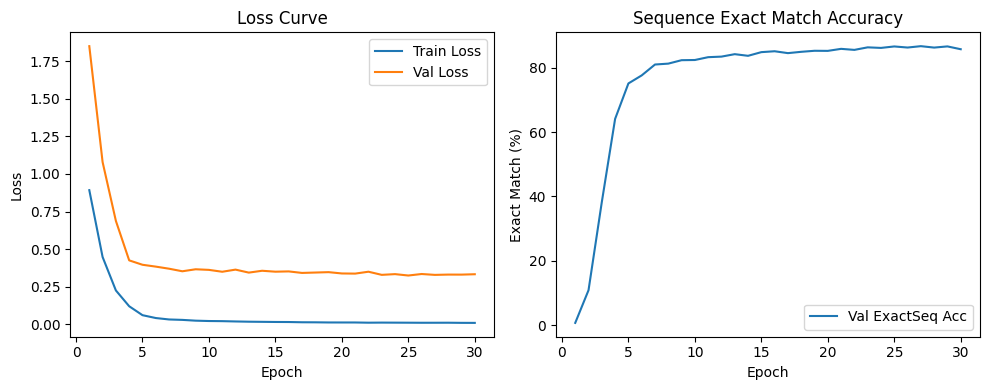


📊 Final Epoch Length-wise Accuracy Table
Length    Accuracy
-------------------------
7         20.00%
10        62.48%
12        92.31%
13        92.04%
14        100.00%
15        92.31%
16        90.50%
17        90.43%
18        100.00%
19        95.24%
20        86.47%
21        100.00%
22        89.95%
23        93.29%
24        100.00%
25        98.31%
26        88.45%
27        100.00%
28        79.18%
29        40.15%
30        60.00%
31        0.00%


In [69]:
#================================================================================
# 8) Colab 셀 8: Loss/Accuracy 시각화 (선택사항)
#================================================================================
import matplotlib.pyplot as plt

# ----- 그래프 -----
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), [acc * 100 for acc in val_seq_accs], label='Val ExactSeq Acc')
plt.xlabel('Epoch')
plt.ylabel('Exact Match (%)')
plt.legend()
plt.title('Sequence Exact Match Accuracy')

plt.tight_layout()
plt.show()

# ----- 마지막 epoch 기준 길이별 정확도 표 -----
print("\n📊 Final Epoch Length-wise Accuracy Table")
final_length_acc = val_len_accs[-1]
print("{:<10}{}".format("Length", "Accuracy"))
print("-" * 25)
for l, a in final_length_acc:
    print("{:<10}{:.2%}".format(l, a))


In [70]:
#================================================================================
# 9) Colab 셀: 모델 불러오기 및 Inference 함수
#================================================================================

import torch
import torch.nn as nn

# (이미 위에서 정의해 두었던 Encoder, Decoder, Seq2Seq 클래스가 런타임에 남아 있다고 가정합니다.)
# 만약 런타임을 재시작했다면, Encoder/Decoder/Seq2Seq 클래스를 다시 정의한 뒤 아래를 실행하세요.

# 1) 저장된 token2idx 불러오기
# ────────────────────────────────────────────────────────────────────────────────
# 이전 셀에서 token2idx를 생성하고 동일 세션에 남아 있는 경우:
#    token2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '1f_1':3, '1f_2':4, 'D=5':5, 'TYPE=Corridor':6, ... }
# 만약 세션을 재시작했거나 따로 파일로 저장한 경우, JSON/피클로 load 해서 token2idx를 복원해야 합니다.
# 예시: token2idx.json 으로 저장해 두었다면 아래처럼 불러올 수 있습니다.
#
# import json
# with open('token2idx.json', 'r', encoding='utf-8') as f:
#     token2idx = json.load(f)

# 이 예시에서는 앞선 셀에서 token2idx가 이미 메모리에 남아 있다고 가정합니다.
# (만약 없다면 위 주석대로 JSON/피클로 복원해 주세요.)
print("Vocab size:", len(token2idx))

# 2) idx2token 생성
idx2token = { idx: tok for tok, idx in token2idx.items() }

# 3) 하이퍼파라미터, Device 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device for inference:", device)

EMBED_DIM = 128      # 앞서 학습할 때 사용한 값과 동일해야 합니다.
HIDDEN_DIM = 256     # 앞서 학습할 때 사용한 값과 동일해야 합니다.
NUM_LAYERS = 1       # 앞서 학습할 때 사용한 값과 동일해야 합니다.
RNN_TYPE = 'LSTM'    # 또는 'GRU' (학습 시점에 지정했던 값과 일치해야 합니다.)

vocab_size = len(token2idx)

# 4) Seq2Seq 모델 인스턴스 생성 & 파라미터 로드
model = Seq2Seq(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, RNN_TYPE).to(device)
model.load_state_dict(torch.load('maze_seq2seq_model.pt', map_location=device))
model.eval()
print("Model loaded from maze_seq2seq_model.pt")

# 5) 추론(inference) 함수 정의
# ────────────────────────────────────────────────────────────────────────────────
#    start_id_str, end_id_str: 예) '1f_1', '1f_2' 등
#    max_len: 디코더가 생성할 최대 토큰 길이 (실제 <EOS> 만나면 곧바로 종료)
def infer_sequence(start_id_str, end_id_str, max_len=50):
    """
    1) 입력 시퀀스: ['<SOS>', start_id_str, end_id_str, '<EOS>']
    2) Encoder → hidden 얻기
    3) Decoder에 <SOS>를 첫 입력으로 주고, 한 스텝씩 예측.
       각 스텝마다 argmax로 다음 토큰 인덱스 골라서 디코더에 다시 입력
    4) <EOS> 인덱스를 만나면 중단. 생성된 인덱스들을 토큰으로 복원하여 리턴.
    """

    # (1) 입력 인덱스로 변환
    if start_id_str not in token2idx or end_id_str not in token2idx:
        raise ValueError(f"'{start_id_str}' 또는 '{end_id_str}' 가 token2idx에 없습니다.")

    sos_idx = token2idx['<SOS>']
    eos_idx = token2idx['<EOS>']
    pad_idx = token2idx['<PAD>']

    # src_idxs: [<SOS>, start, end, <EOS>]
    src_idxs = [sos_idx, token2idx[start_id_str], token2idx[end_id_str], eos_idx]
    src_tensor = torch.tensor(src_idxs, dtype=torch.long, device=device).unsqueeze(0)  # (1, src_len)
    src_lens   = torch.tensor([len(src_idxs)], dtype=torch.long, device=device)       # (1,)

    # (2) Encoder forward -> hidden
    #     LSTM일 때는 (h_n, c_n)이 반환, GRU일 때는 h_n 반환
    with torch.no_grad():
        enc_hidden = model.encoder(src_tensor, src_lens)

    # (3) Decoder 초기 입력: <SOS> 하나만
    dec_input = torch.tensor([[sos_idx]], dtype=torch.long, device=device)  # shape=(1,1)
    dec_hidden = enc_hidden  # LSTM이면 (h_n, c_n), GRU이면 h_n

    generated_idxs = []

    # (4) 한 스텝씩 생성
    for t in range(max_len):
        # dec_input: (1,1)  → embedding → rnn → linear → logits(1, vocab_size)
        emb = model.decoder.embedding(dec_input)  # (1,1, E)
        if RNN_TYPE == 'LSTM':
            out, dec_hidden = model.decoder.rnn(emb, dec_hidden)
        else:
            out, dec_hidden = model.decoder.rnn(emb, dec_hidden)
        logits = model.decoder.out(out.squeeze(1))  # (1, vocab_size)

        # Greedy: 가장 높은 확률의 토큰 선택
        next_idx = logits.argmax(dim=1).item()  # 스칼라
        generated_idxs.append(next_idx)

        # <EOS> 나오면 중단
        if next_idx == eos_idx:
            break

        # 다음 디코더 입력으로 바로 넣음
        dec_input = torch.tensor([[next_idx]], dtype=torch.long, device=device)

    # 생성된 인덱스 리스트 → 토큰 리스트로 변환
    # (예: [D=5, TYPE=Corridor, TURN_RIGHT, D=5, TYPE=Room, END, <EOS>])
    generated_tokens = [ idx2token[idx] for idx in generated_idxs ]

    # <EOS> 이후 토큰(있다면) 제거. (보통 EOS 직전까지가 우리가 원하는 “END” 토큰까지의 시퀀스)
    if '<EOS>' in generated_tokens:
        eos_pos = generated_tokens.index('<EOS>')
        generated_tokens = generated_tokens[:eos_pos]

    return generated_tokens

#================================================================================
# 6) 테스트: 실제로 방 ID 조합을 넣어보고 결과 확인
#================================================================================

# 예시 1:
result1 = infer_sequence('27117', '25112')
print("Input:  27117  →  25112")
print("Output: ", result1)
# 예시 출력 형태: ['D=5', 'TYPE=Corridor', 'TURN_RIGHT', 'D=5', 'TYPE=Room', 'END']

# 예시 2:
result2 = infer_sequence('27113', '25312')
print("\nInput:  27113  →  25312")
print("Output: ", result2)
# 예시 출력 형태: ['D=5', 'TYPE=Corridor', 'TURN_RIGHT', 'D=10', 'TYPE=Corridor', 'TURN_LEFT', 'D=5', 'TYPE=Room', 'END']


Vocab size: 288
Using device for inference: cuda
Model loaded from maze_seq2seq_model.pt
Input:  27117  →  25112
Output:  ['D=5', 'TYPE=Corridor', 'TURN_LEFT', 'D=70', 'TYPE=Corridor', 'TURN_RIGHT', 'D=85', 'TYPE=Corridor', 'TURN_RIGHT', 'D=50', 'TYPE=Corridor', 'TURN_RIGHT', 'D=5', 'TYPE=Room', 'END']

Input:  27113  →  25312
Output:  ['D=5', 'TYPE=Corridor', 'TURN_LEFT', 'D=55', 'TYPE=Corridor', 'TURN_RIGHT', 'D=85', 'TYPE=Corridor', 'TURN_RIGHT', 'D=15', 'TYPE=Corridor', 'TURN_RIGHT', 'D=5', 'TYPE=Elevator', 'D=0', 'TYPE=Elevator', 'D=0', 'TYPE=Elevator', 'D=5', 'TYPE=Corridor', 'TURN_RIGHT', 'D=55', 'TYPE=Corridor', 'TURN_RIGHT', 'D=5', 'TYPE=Room', 'END']
